# Recon ML System

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from functions_ml import *
model_repo = ".\\Recon_model\\"

## Preprocessing data for binary classification (Recon or Benign)

### Import basic datasets

In [2]:
train_sets, test_sets = get_train_and_test_files()
print(len(train_sets), len(test_sets))

X_columns = x_columns(read_csv_file(train_sets[0]))
y_column = 'label'

file_path = '.\Files\\Recon\\'

135 34


### Scaling

In [3]:
scaler = get_or_define_and_save_scaler(model_repo, train_sets, X_columns)

### Dictionnary for spliting data

In [4]:
dict_3_classes = {}
dict_3_classes['Recon-PingSweep'] = 'Recon'
dict_3_classes['Recon-OSScan'] = 'Recon'
dict_3_classes['Recon-PortScan'] = 'Recon'
dict_3_classes['VulnerabilityScan'] = 'Recon'
dict_3_classes['Recon-HostDiscovery'] = 'Recon'

dict_3_classes['BenignTraffic'] = 'Benign'

dict_3_classes['DDoS-RSTFINFlood'] = 'Other'
dict_3_classes['DDoS-PSHACK_Flood'] = 'Other'
dict_3_classes['DDoS-SYN_Flood'] = 'Other'
dict_3_classes['DDoS-UDP_Flood'] = 'Other'
dict_3_classes['DDoS-TCP_Flood'] = 'Other'
dict_3_classes['DDoS-ICMP_Flood'] = 'Other'
dict_3_classes['DDoS-SynonymousIP_Flood'] = 'Other'
dict_3_classes['DDoS-ACK_Fragmentation'] = 'Other'
dict_3_classes['DDoS-UDP_Fragmentation'] = 'Other'
dict_3_classes['DDoS-ICMP_Fragmentation'] = 'Other'
dict_3_classes['DDoS-SlowLoris'] = 'Other'
dict_3_classes['DDoS-HTTP_Flood'] = 'Other'
dict_3_classes['DoS-UDP_Flood'] = 'Other'
dict_3_classes['DoS-SYN_Flood'] = 'Other'
dict_3_classes['DoS-TCP_Flood'] = 'Other'
dict_3_classes['DoS-HTTP_Flood'] = 'Other'
dict_3_classes['Mirai-greeth_flood'] = 'Other'
dict_3_classes['Mirai-greip_flood'] = 'Other'
dict_3_classes['Mirai-udpplain'] = 'Other'
dict_3_classes['DNS_Spoofing'] = 'Other'
dict_3_classes['MITM-ArpSpoofing'] = 'Other'
dict_3_classes['BrowserHijacking'] = 'Other'
dict_3_classes['Backdoor_Malware'] = 'Other'
dict_3_classes['XSS'] = 'Other'
dict_3_classes['Uploading_Attack'] = 'Other'
dict_3_classes['SqlInjection'] = 'Other'
dict_3_classes['CommandInjection'] = 'Other'
dict_3_classes['DictionaryBruteForce'] = 'Other'

### Refactoring data

In [5]:
train_sets.extend(test_sets)
refactor_dataframe(train_sets, dict_3_classes, file_path, y_column)

100%|██████████| 168/168 [02:25<00:00,  1.16it/s]


### Counting number of samples per class

5


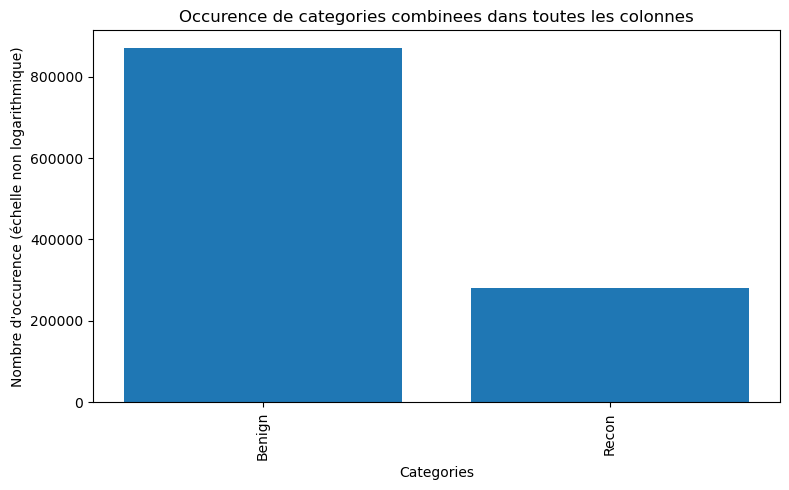

In [6]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(train_sets) + len(test_sets))

plot_bar_chart(count_label(train_sets, file_path=file_path), 'Occurence de categories combinees dans toutes les colonnes', 'Categories', 'Nombre d\'occurence', 8, 5, log_scale=False)

## Define variables

In [4]:
performance_path = 'performance.csv'
file_path = '.\Files\\Recon\\'
model_path_binary = '.\\Recon_model\\Binary\\'
local_path = '.\\Recon_model\\'
model_path_all_classes = '.\\Recon_model\\All_classes\\'
filter_name = 'Recon'
after_build_csv = 'after_build_set_scaled.csv'

# Get path data
build_sets, after_build_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(build_sets) + len(after_build_sets))

# Get build datasets
build_nb = round(len(build_sets) * 0.8)
train_sets = build_sets[:build_nb]
# train_sets = train_sets[: round(len(train_sets) * 0.5)]
test_sets = build_sets[build_nb:]
# test_sets = test_sets[: round(len(test_sets) * 0.5)]

# Define different columns
X_columns = x_columns(read_csv_file(train_sets[0], path_to_datasets=file_path))
print(len(X_columns))
X_columns = X_columns[:-1]
y_column = 'label'
z_column = 'Binary'

5
47


## First model (Binary (Recon or Benigh))

### Building model

In [6]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
]

In [7]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_binary)
performance = get_or_define_performance_df(model_path_binary, performance_path)

# Buidling models
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path_binary, X_columns=X_columns , y_column=z_column, encoder=encoder, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path_binary + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path_binary+'encoder.joblib')

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [04:29<00:00, 89.82s/it] 


['.\\Recon_model\\Binary\\encoder.joblib']

#### Hyperparameters tuning

In [15]:
param_space_decision_tree = {
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}

param_space_random_forest = {
    'n_estimators': (10, 200),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'max_features': (0.1, 1.0),
}

param_space_xgboost = {
    'n_estimators': (10, 200),
    'max_depth': (1, 20),
    'learning_rate': (0.01, 1.0),
}

simpleModelsDef[0]['param_space'] = param_space_decision_tree
simpleModelsDef[1]['param_space'] = param_space_random_forest
simpleModelsDef[2]['param_space'] = param_space_xgboost

In [16]:
model_path = '.\\Recon_model\\Binary\\'
performance_path = 'tuning_performance.csv'

try:
    # Load the encoder from a file
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    # scaler = MinMaxScaler()
    encoder = LabelEncoder()

# Hyperparameters tuning models
for model in tqdm(simpleModelsDef):
    optimize_hyperparameters(model['Model'], model['Name'], file_path, model_path, model['param_space'], train_sets, X_columns, y_column=z_column, encoder=encoder, scaler=scaler, n_splits=5, n_iter=10)


# try:
#     # Load performance dataframe
#     performance = read_csv_file(performance_path, model_path)
# except:
#     # Define performance dataframe
#     performance = pd.DataFrame(columns=['Model', 'Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate', 'FU', 'FL', 'Total rows'])

# # Buidling models
# for model in tqdm(simpleModelsDef):
#     # Build model
#     performance, encoder = build_model(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path, X_columns=X_columns , y_column=z_column, encoder=encoder, scaler=scaler, confusionMatrix=False)

#     # Save performance
#     performance.to_csv(model_path + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path+'encoder.joblib')

100%|██████████| 3/3 [3:02:20<00:00, 3646.70s/it]  


['.\\Recon_model\\Binary\\encoder.joblib']

#### Display performance

In [15]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_binary)
performance = performance.drop(3).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path_binary + performance_path, index=False)

In [17]:
read_csv_file(performance_path, model_path_binary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
2,XGB,0.970008,0.948019,0.969916,0.958356,0.962730,0.936981,0.960772,0.948136,0.009664,0.027606,2915,8327,301637
1,RF,0.999978,0.999972,0.999967,0.999970,0.961053,0.932959,0.960175,0.945599,0.009246,0.029701,2789,8959,301637
0,DT,0.999985,0.999987,0.999972,0.999979,0.944712,0.925524,0.924660,0.925091,0.028010,0.027278,8449,8228,301637


## Do prediction for after build sets

In [5]:
# Define model and import encoder
model = joblib.load(model_path_binary + 'model_XGB.joblib')
encoder = get_encoder(model_path_binary, "Please, build binary model(s) first")

# Get prediction
new_after_build_set, y_test, y_pred, z_test = get_prediction_by_model_s(model, after_build_sets, file_path, X_columns, y_column=z_column, z_column=y_column, scale=True, encode=True, scaler=scaler, encoder=encoder)

# Build new dataframe
new_after_build_set[z_column] = encoder.inverse_transform(y_test)
new_after_build_set['Prediction'] = encoder.inverse_transform(y_pred)
new_after_build_set[y_column] = z_test
count = len(new_after_build_set[new_after_build_set[z_column] != new_after_build_set['Prediction']])

# Save dataframe
new_after_build_set.to_csv(local_path + after_build_csv, index=False)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set) * 100,len(new_after_build_set)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows'])

del new_after_build_set

res.head()

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.963103,0.963103,0.962985,0.962626,11161,3.689697,302491


## Second model (All Recon classes)

### Building model

In [6]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
]

In [7]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_all_classes)
performance = get_or_define_performance_df(model_path_all_classes, performance_path)

# Buidling models
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path_all_classes, X_columns=X_columns , y_column=y_column, z_column=z_column, encoder=encoder, filter_bool=True, filter_name=filter_name, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path_all_classes + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path_all_classes+'encoder.joblib')

100%|██████████| 3/3 [01:20<00:00, 26.83s/it]


['.\\Recon_model\\All_classes\\encoder.joblib']

### Display performance

In [ ]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_all_classes)
performance = performance.drop(3).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path + performance_path, index=False)

In [8]:
read_csv_file(performance_path, model_path_all_classes).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
2,XGB,0.934831,0.939892,0.951827,0.945679,0.894860,0.838811,0.907238,0.865206,0.047877,0.057263,3520,4210,73521
1,RF,0.992818,0.993519,0.994348,0.993932,0.880946,0.745639,0.895455,0.768296,0.045701,0.073353,3360,5393,73521
0,DT,0.995183,0.995172,0.996322,0.995744,0.850723,0.808858,0.794835,0.801374,0.076332,0.072945,5612,5363,73521


## Final Prediction

In [11]:
# Define model and import encoder
model = joblib.load(model_path_all_classes + 'model_XGB.joblib')
encoder = get_encoder(model_path_all_classes, "Please, build binary model(s) first")

# Get binary col to include it into the new df
pred_column = 'Prediction'
binary_col = get_col_in_csv(after_build_csv, model_repo, z_column, pred_column, filter_name, filter=True, verbose=True)

# Get prediction
new_after_build_set, y_test, y_pred, z_test = get_prediction_by_model_s(model, [after_build_csv], model_repo, X_columns, y_column=y_column, z_column=pred_column, filter_bool=True, filter_name=filter_name, scale=True, encode=False, scaler=scaler, encoder=encoder)

# Build new dataframe and save it
new_after_build_set[y_column] = y_test
new_after_build_set['Final Prediction'] = encoder.inverse_transform(y_pred)
new_after_build_set[z_column] = binary_col
new_after_build_set['Prediction'] = z_test
count = len(new_after_build_set[new_after_build_set[y_column] != new_after_build_set['Final Prediction']])
y_pred = encoder.inverse_transform(y_pred)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set),len(new_after_build_set)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows']).head()

res.head()

Dataframe length: 302491.
After reduction dataframe length: 68920.


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.88372,0.88372,0.847486,0.864784,8014,0.11628,68920


In [12]:
labelBenignTraffic = new_after_build_set[
    (new_after_build_set['label'] == 'BenignTraffic') &
    (new_after_build_set['Final Prediction'] != 'BenignTraffic')
]
FinalBenighTraffic = new_after_build_set[
    (new_after_build_set['label'] != 'BenignTraffic') &
    (new_after_build_set['Final Prediction'] == 'BenignTraffic')
]
GoodBenignTraffic = new_after_build_set[
    (new_after_build_set['label'] == 'BenignTraffic') &
    (new_after_build_set['Final Prediction'] == 'BenignTraffic')
]

del new_after_build_set

In [13]:
print(len(labelBenignTraffic), len(FinalBenighTraffic), len(GoodBenignTraffic))

2896 0 0
